## 288 - Making a Weather Front Map in Python

[Youtube](https://www.youtube.com/watch?v=C4fQ23zlA3o)

In [1]:
import matplotlib.pyplot as plt
import urllib.request

from metpy.io import parse_wpc_surface_bulletin
from io import BytesIO

In [2]:
url = 'https://www.wpc.ncep.noaa.gov/discussions/codsus'

In [3]:
with urllib.request.urlopen(url) as response:
    content = response.read()

In [4]:
content

b' \nCODED SURFACE FRONTAL POSITIONS\nNWS WEATHER PREDICTION CENTER COLLEGE PARK MD\n924 PM EDT MON JUN 12 2023\n \nVALID 061300Z\nHIGHS 1013 3189 1013 3494 1013 3698 1013 4096 1014 4299 1013 49108 1015 44110 \n1014 45115 1013 38113 1014 40105 1011 5479 1013 5467 1010 4661 1021 6197 1020 \n70107 1021 64103 1010 4790 1016 51115 1014 55109 1020 6739 1033 50146 1016 \n5967 1014 52121 \nLOWS 1002 20101 1002 32103 1006 37105 1005 35115 1005 3579 999 4579 1002 4076 \n1001 4682 1005 4488 1007 37116 1010 41123 1004 39108 1010 45106 1010 44114 \n1008 4765 1007 5585 1007 5399 1005 5591 1010 56103 1009 58120 1010 53117 1008 \n39106 999 71155 998 70137 1002 61164 1002 34105 1003 31100 1003 3877 998 5335 \n998 5645 1003 6660 991 7362 1025 47143 \nTROF 2389 2190 1990 1790 \nTROF 3082 2981 2781 2681 \nTROF 28105 26103 24102 22102 20101 1999 1897 \nSTNRY WK 32103 32103 33103 33103 34104 34104 35105 36105 37105 37105 \nTROF 3390 3394 3296 \nCOLD WK 3579 3382 3285 \nOCFNT WK 4579 4478 4377 4177 4176 407

In [5]:
df = parse_wpc_surface_bulletin(BytesIO(content))

In [6]:
df

,valid,feature,strength,geometry
0,2023-06-13,HIGH,1013,POINT (-89 31)
1,2023-06-13,HIGH,1013,POINT (-94 34)
2,2023-06-13,HIGH,1013,POINT (-98 36)
3,2023-06-13,HIGH,1013,POINT (-96 40)
4,2023-06-13,HIGH,1014,POINT (-99 42)
...,...,...,...,...
140,2023-06-13,TROF,NaN,"LINESTRING (-98 31, -97 31, -96 30, -95 29)"
141,2023-06-13,TROF,NaN,"LINESTRING (-118 43, -120 42, -123 41)"
142,2023-06-13,TROF,NaN,"LINESTRING (-118 40, -118 39, -116 37)"
143,2023-06-13,TROF,NaN,"LINESTRING (-102 46, -104 46, -106 45)"


In [7]:
df['feature'].unique()

array(['HIGH', 'LOW', 'TROF', 'STNRY', 'COLD', 'OCFNT', 'WARM'],
      dtype=object)

In [8]:
df['feature'].value_counts()

feature
TROF     57
LOW      33
HIGH     23
STNRY    14
COLD     12
OCFNT     3
WARM      3
Name: count, dtype: int64

Text(0.5, 1.0, 'Current Low and High Strengths')

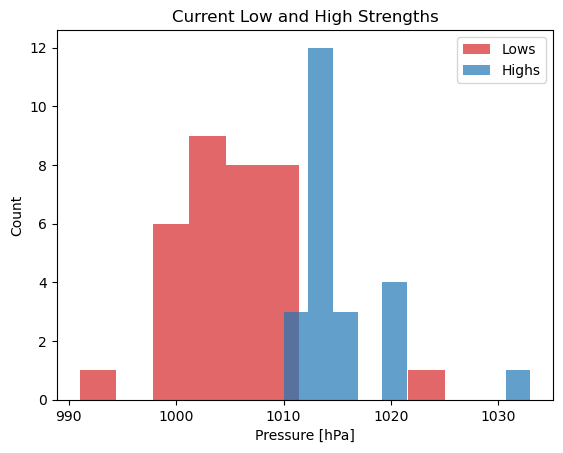

In [9]:
fig, ax = plt.subplots()
low_strength = df[df['feature']=='LOW'].strength
high_strength = df[df['feature']=='HIGH'].strength
ax.hist(low_strength, color='tab:red', alpha=0.7, label='Lows')
ax.hist(high_strength, color='tab:blue', alpha=0.7, label='Highs')
ax.legend()
ax.set_xlabel('Pressure [hPa]')
ax.set_ylabel('Count')
plt.title('Current Low and High Strengths')

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ColdFront, WarmFront, OccludedFront, StationaryFront

In [11]:
map_crs = ccrs.LambertConformal(central_latitude=45, central_longitude=-100)

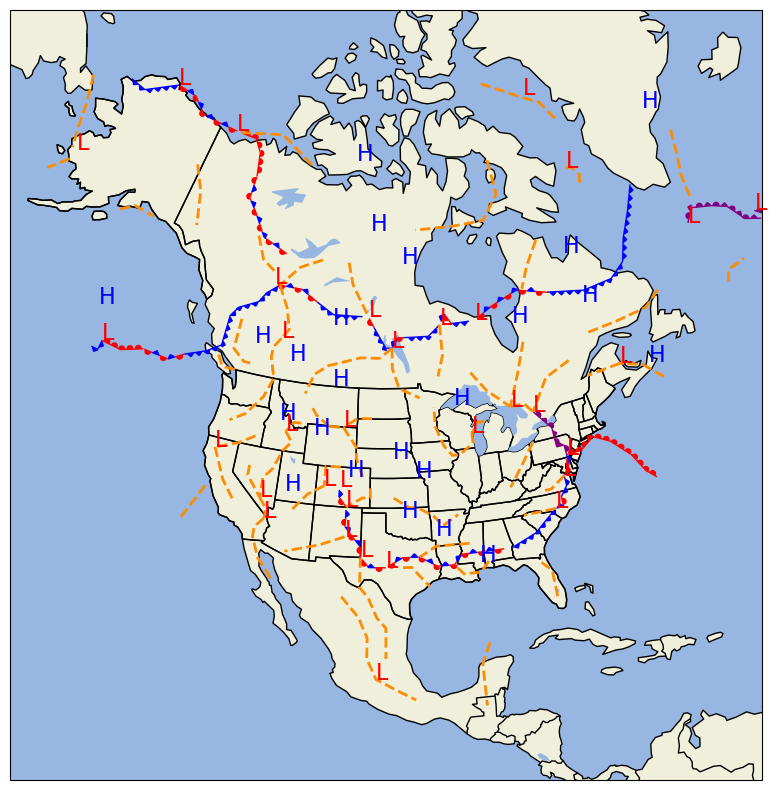

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=map_crs)
ax.set_extent((-135, -65, 10, 80), crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES)

features = df[df['feature']=='LOW']
for f in features['geometry']:
    ax.text(f.x, f.y, 'L', transform=ccrs.PlateCarree(), color='red', fontsize=16)

features = df[df['feature']=='HIGH']
for f in features['geometry']:
    ax.text(f.x, f.y, 'H', transform=ccrs.PlateCarree(), color='blue', fontsize=16)

s = 2
feature_names = ['WARM', 'COLD', 'STNRY', 'OCFNT', 'TROF']
feature_styles = [{'linewidth': 1, 'path_effects': [WarmFront(size=s)]},
                  {'linewidth': 1, 'path_effects': [ColdFront(size=s)]},
                  {'linewidth': 1, 'path_effects': [StationaryFront(size=s)]},
                  {'linewidth': 1, 'path_effects': [OccludedFront(size=s)]},
                  {'linewidth': 2, 'linestyle': 'dashed', 'edgecolor': 'darkorange'}]

for name, style in zip(feature_names, feature_styles):
    f = df[df['feature'] == name]
    ax.add_geometries(f.geometry, crs=ccrs.PlateCarree(), **style, facecolor='none')
                                                    